In [4]:
# Install fluidsynth for MIDI synthesis
!sudo apt-get install -y fluidsynth

# Upgrade pyfluidsynth and install pretty_midi
!pip install --upgrade pyfluidsynth pretty_midi

# Additional installations if necessary
!pip install music21

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin
  libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5
  libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme qttranslations5-l10n
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs qt5-image-formats-plugins qtwayland5 jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libevdev2 libfluidsynth3 libgudev-1.0-0
  libinput-bin libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a
  libqt5dbus5 libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libx

In [5]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf
from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

# Set seed for reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

In [6]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
    tf.keras.utils.get_file(
        'maestro-v2.0.0-midi.zip',
        origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
        extract=True,
        cache_dir='.', cache_subdir='data',
    )

59243107/59243107 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
    """
    Synthesizes the MIDI file into audio and displays it.

    Args:
        pm (pretty_midi.PrettyMIDI): The PrettyMIDI object.
        seconds (int, optional): Number of seconds to play. Defaults to 30.
    """
    waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
    waveform_short = waveform[:seconds * _SAMPLING_RATE]
    return display.Audio(waveform_short, rate=_SAMPLING_RATE)

# Select a sample MIDI file
filenames = glob.glob(str(data_dir/'**/*.mid*'), recursive=True)
sample_file = filenames[1]
pm = pretty_midi.PrettyMIDI(sample_file)
display_audio(pm)

In [10]:
import glob
import pathlib
import pretty_midi
import pandas as pd
import collections
import numpy as np
import music21

# Step 1: Locate a Sample MIDI File
data_dir = pathlib.Path('data/maestro-v2.0.0')
midi_files = glob.glob(str(data_dir/'**/*.mid*'), recursive=True)

if not midi_files:
    raise FileNotFoundError("No MIDI files found in the Maestro dataset directory.")

sample_midi_file = midi_files[0]
print(f"Selected MIDI file: {sample_midi_file}")

# Step 2: Function to Extract Notes
def midi_to_notes(midi_file: str) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(midi_file)

    if not pm.instruments:
        raise ValueError("No instruments found in the MIDI file.")

    instrument = pm.instruments[0]
    notes = collections.defaultdict(list)
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start if sorted_notes else 0

    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start - prev_start)
        notes['duration'].append(end - start)
        prev_start = start

    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

# Extract raw_notes
try:
    raw_notes = midi_to_notes(sample_midi_file)
    print("Raw Notes Extracted:")
    print(raw_notes.head())
except Exception as e:
    print(f"An error occurred while processing the MIDI file: {e}")

# Step 3: Function to Enforce Major Key
def enforce_major_key(notes: pd.DataFrame, key: str = 'C') -> pd.DataFrame:
    scale = music21.scale.MajorScale(key)
    scale_pitches = [p.midi for p in scale.getPitches()]

    def snap_pitch(pitch):
        nearest = min(scale_pitches, key=lambda x: abs(x - pitch))
        return nearest

    notes['pitch'] = notes['pitch'].apply(snap_pitch)
    return notes

# Enforce C Major key
try:
    adjusted_notes = enforce_major_key(raw_notes, key='C')
    print("\nAdjusted Notes (Major Key):")
    print(adjusted_notes.head())
except Exception as e:
    print(f"An error occurred while enforcing the major key: {e}")

Selected MIDI file: data/maestro-v2.0.0/2014/MIDI-UNPROCESSED_09-10_R1_2014_MID--AUDIO_10_R1_2014_wav--1.midi
Raw Notes Extracted:
   pitch     start       end      step  duration
0     48  0.959635  2.052083  0.000000  1.092448
1     60  1.128906  1.182292  0.169271  0.053385
2     63  1.291667  1.343750  0.162760  0.052083
3     67  1.437500  1.475260  0.145833  0.037760
4     72  1.598958  1.643229  0.161458  0.044271

Adjusted Notes (Major Key):
   pitch     start       end      step  duration
0     60  0.959635  2.052083  0.000000  1.092448
1     60  1.128906  1.182292  0.169271  0.053385
2     62  1.291667  1.343750  0.162760  0.052083
3     67  1.437500  1.475260  0.145833  0.037760
4     72  1.598958  1.643229  0.161458  0.044271


In [11]:
import music21

def enforce_major_key(notes: pd.DataFrame, key: str = 'C') -> pd.DataFrame:
    """
    Adjusts the pitches of the notes to fit within the specified major scale.

    Args:
        notes (pd.DataFrame): DataFrame containing 'pitch', 'step', 'duration'.
        key (str, optional): The major key to enforce. Defaults to 'C'.

    Returns:
        pd.DataFrame: Adjusted notes fitting the major scale.
    """
    scale = music21.scale.MajorScale(key)
    scale_pitches = [p.midi for p in scale.getPitches()]

    def snap_pitch(pitch):
        # Find the nearest pitch in the major scale
        nearest = min(scale_pitches, key=lambda x: abs(x - pitch))
        return nearest

    notes['pitch'] = notes['pitch'].apply(snap_pitch)
    return notes

# Example usage:
adjusted_notes = enforce_major_key(raw_notes, key='C')
print(adjusted_notes.head())

   pitch     start       end      step  duration
0     60  0.959635  2.052083  0.000000  1.092448
1     60  1.128906  1.182292  0.169271  0.053385
2     62  1.291667  1.343750  0.162760  0.052083
3     67  1.437500  1.475260  0.145833  0.037760
4     72  1.598958  1.643229  0.161458  0.044271



Sample of extracted notes:
   pitch     start       end      step  duration
0     38  1.020833  1.214844  0.000000  0.194010
1     41  1.062500  1.247396  0.041667  0.184896
2     45  1.110677  1.259115  0.048177  0.148438
3     50  1.153646  1.276042  0.042969  0.122396
4     62  1.167969  1.281250  0.014323  0.113281


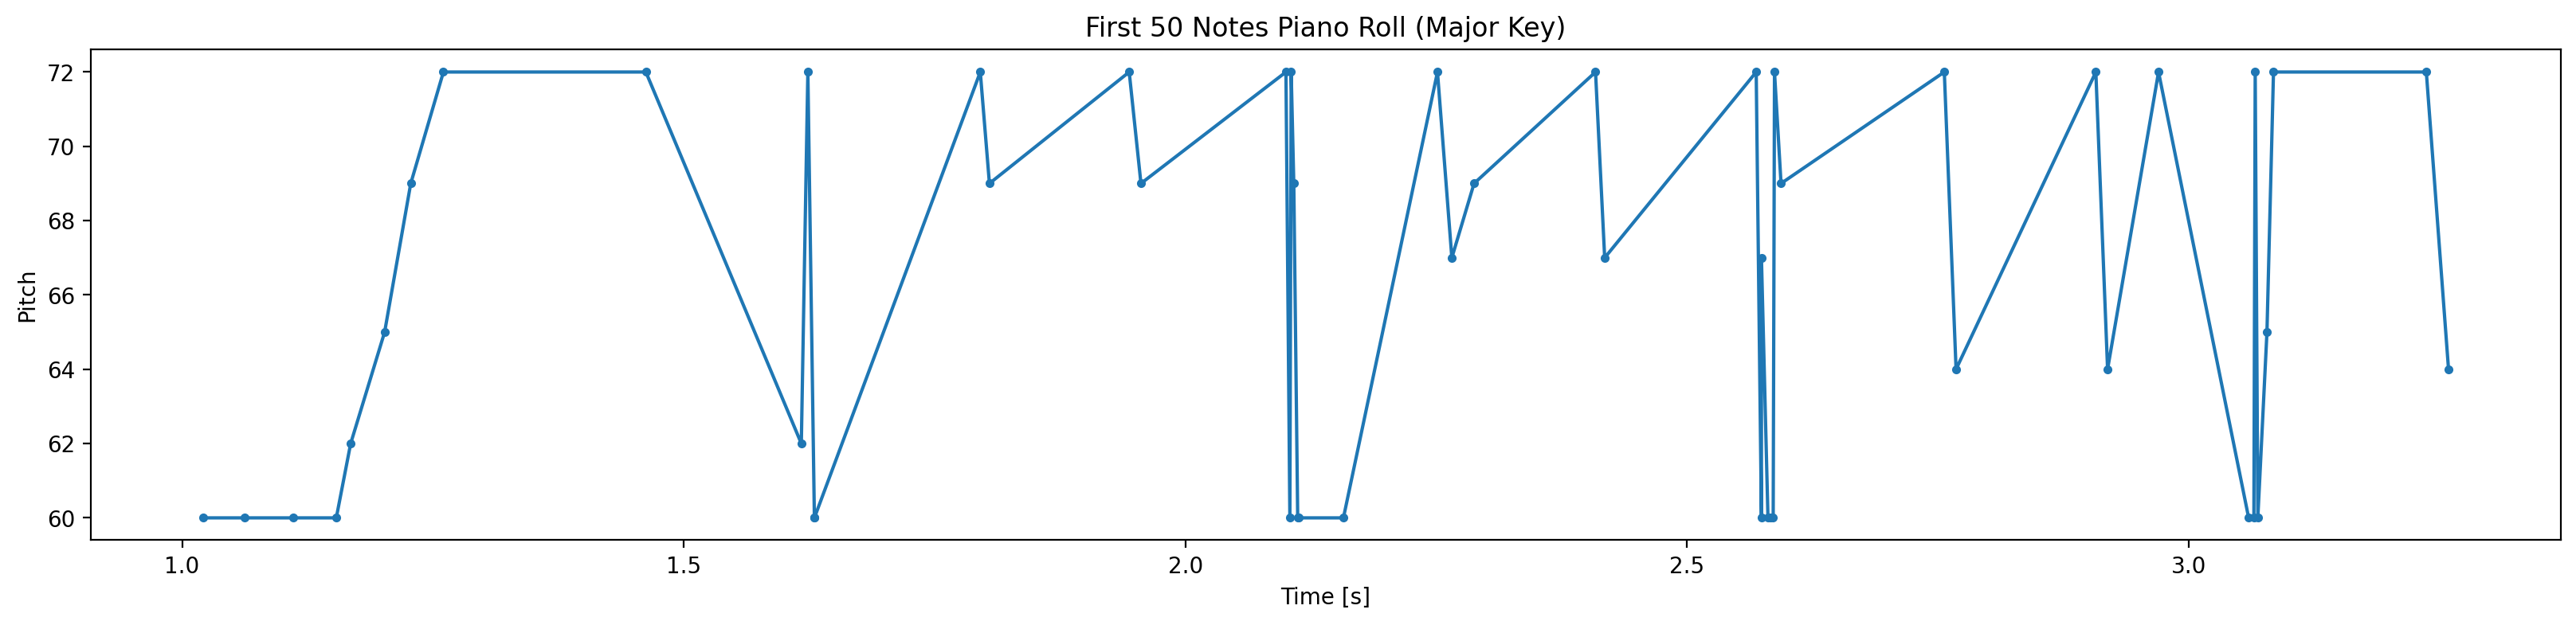

In [12]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
    """
    Extracts notes from a MIDI file.

    Args:
        midi_file (str): Path to the MIDI file.

    Returns:
        pd.DataFrame: DataFrame containing 'pitch', 'start', 'end', 'step', 'duration'.
    """
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0]
    notes = collections.defaultdict(list)

    # Sort notes by start time
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start

    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start - prev_start)
        notes['duration'].append(end - start)
        prev_start = start

    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

# Load and extract notes from the sample MIDI file
raw_notes = midi_to_notes(sample_file)
print("\nSample of extracted notes:")
print(raw_notes.head())

# Enforce major key
adjusted_notes = enforce_major_key(raw_notes, key='C')

# Plot the piano roll for adjusted notes
def plot_piano_roll(notes: pd.DataFrame, count: int = 50):
    """
    Plots the piano roll of the first 'count' notes.

    Args:
        notes (pd.DataFrame): DataFrame containing note information.
        count (int, optional): Number of notes to plot. Defaults to 50.
    """
    plt.figure(figsize=(20, 4))
    plt.plot(notes['start'][:count], notes['pitch'][:count], marker='.', linestyle='-')
    plt.xlabel('Time [s]')
    plt.ylabel('Pitch')
    plt.title(f'First {count} Notes Piano Roll (Major Key)')
    plt.show()

plot_piano_roll(adjusted_notes, count=50)

In [13]:
# Define key order
key_order = ['pitch', 'step', 'duration']

# Stack the notes into a NumPy array for training
train_notes = np.stack([adjusted_notes[key] for key in key_order], axis=1)

# Create a TensorFlow dataset from the notes
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)

def create_sequences(dataset: tf.data.Dataset, seq_length: int, vocab_size: int = 128) -> tf.data.Dataset:
    """
    Creates input-output pairs for the model.

    Args:
        dataset (tf.data.Dataset): Dataset of notes.
        seq_length (int): Length of the input sequences.
        vocab_size (int, optional): Number of unique pitches. Defaults to 128.

    Returns:
        tf.data.Dataset: Dataset of (input_sequence, target_note).
    """
    # Create sliding windows of seq_length + 1
    sequences = dataset.window(seq_length + 1, shift=1, drop_remainder=True)
    sequences = sequences.flat_map(lambda window: window.batch(seq_length + 1))

    def scale_pitch(x):
        # Normalize pitches to [0, 1] range
        x = x / [vocab_size, 1.0, 1.0]
        return x

    def split_input_target(window):
        # Split into input and target
        input_seq = window[:-1]
        target = window[-1]
        input_seq = scale_pitch(input_seq)
        return input_seq, target

    return sequences.map(split_input_target, num_parallel_calls=tf.data.AUTOTUNE)

# Parameters
seq_length = 25  # Length of each input sequence
vocab_size = 128  # Number of possible pitch values

# Create sequences
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)

# Shuffle and batch the dataset
batch_size = 64
buffer_size = 1000  # Adjust based on dataset size

train_ds = seq_ds.shuffle(buffer_size).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

print(f"\nTraining dataset prepared with batch size {batch_size} and sequence length {seq_length}.")


Training dataset prepared with batch size 64 and sequence length 25.


In [14]:
from tensorflow.keras import layers, models

# Define the model architecture
model = models.Sequential([
    layers.Input(shape=(seq_length, 3)),  # Input shape: (sequence_length, features)
    layers.LSTM(256, return_sequences=False),  # LSTM layer with 256 units
    layers.Dense(128, activation='relu'),  # Fully connected layer
    layers.Dense(3)  # Output layer for pitch, step, duration
])

# Compile the model with appropriate loss functions and optimizer
model.compile(
    loss='mse',  # Mean Squared Error loss
    optimizer='adam',
    metrics=['mae']  # Mean Absolute Error metric
)

# Display the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 256)                 │         266,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 299,523 (1.14 MB)

 Trainable params: 299,523 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Define training parameters
epochs = 50  # Adjust as needed; more epochs may improve performance

# Train the model
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=[
        # ModelCheckpoint to save the full model in .keras format
        tf.keras.callbacks.ModelCheckpoint(
            filepath='model_checkpoint.keras',  # Changed extension to .keras
            save_best_only=True,
            monitor='loss',
            mode='min'
        ),
        # EarlyStopping to prevent overfitting
        tf.keras.callbacks.EarlyStopping(
            monitor='loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

print("\nTraining completed.")

Epoch 1/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - loss: 443.7145 - mae: 9.2382
Epoch 2/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


133/133 ━━━━━━━━━━━━━━━━━━━━ 15s 113ms/step - loss: 9.1779 - mae: 1.7529
Epoch 3/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - loss: 9.1124 - mae: 1.7392
Epoch 4/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 21s 118ms/step - loss: 9.1257 - mae: 1.7551
Epoch 5/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 15s 113ms/step - loss: 9.1134 - mae: 1.7429
Epoch 6/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 15s 113ms/step - loss: 9.2031 - mae: 1.7567
Epoch 7/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 15s 113ms/step - loss: 9.1956 - mae: 1.7478
Epoch 8/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - loss: 9.0942 - mae: 1.7441
Epoch 9/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 21s 113ms/step - loss: 9.0714 - mae: 1.7479
Epoch 10/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - loss: 9.1117 - mae: 1.7440
Epoch 11/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 17s 126ms/step - loss: 9.1090 - mae: 1.7479
Epoch 12/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 15s 112ms/step - loss: 9.1338 - mae: 1.7431
Epoch 13/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 21s 113ms/step - loss: 9.1668 - mae: 1.7406

In [17]:
def generate_melody(model: tf.keras.Model, seed: np.ndarray, length: int = 360, temperature: float = 1.0) -> list:
    """
    Generates a sequence of notes using the trained model.

    Args:
        model (tf.keras.Model): Trained LSTM model.
        seed (np.ndarray): Seed sequence to start the generation.
        length (int, optional): Number of notes to generate. Defaults to 360.
        temperature (float, optional): Controls the randomness of predictions. Defaults to 1.0.

    Returns:
        list: Generated notes as tuples of (pitch, step, duration).
    """
    generated = []
    input_seq = seed.copy()
    prev_start = 0.0

    for _ in range(length):
        input_scaled = input_seq / [vocab_size, 1.0, 1.0]  # Normalize
        input_scaled = np.expand_dims(input_scaled, axis=0)  # Add batch dimension
        prediction = model.predict(input_scaled, verbose=0)[0]

        # Apply temperature to predictions (optional)
        pitch_pred = prediction[0] / temperature
        step_pred = max(prediction[1], 0.01)  # Ensure non-negative step
        duration_pred = max(prediction[2], 0.1)  # Ensure non-negative duration

        # Convert predictions to valid ranges
        pitch = int(np.clip(pitch_pred * vocab_size, 20, 100))  # Adjust as needed
        step = float(step_pred)
        duration = float(duration_pred)

        generated.append((pitch, step, duration))
        prev_start += step

        # Update the input sequence by removing the first note and adding the new one
        new_note = [pitch, step, duration]
        input_seq = np.roll(input_seq, -1, axis=0)
        input_seq[-1] = new_note

    return generated

# Use the first 'seq_length' notes as the seed
seed_notes = train_notes[:seq_length]

# Generate 360 notes (~30 seconds assuming average step duration)
generated_notes = generate_melody(model, seed_notes, length=360, temperature=1.0)

# Convert the generated notes to a DataFrame
generated_df = pd.DataFrame(generated_notes, columns=key_order)
print("\nSample of generated notes:")
print(generated_df.head())


Sample of generated notes:
   pitch      step  duration
0    100  0.196043  0.263629
1    100  0.194073  0.268168
2    100  0.194059  0.268211
3    100  0.194059  0.268213
4    100  0.194059  0.268213


In [38]:
def notes_to_midi(notes: pd.DataFrame, out_file: str, instrument_name: str) -> pretty_midi.PrettyMIDI:
    """
    Converts notes to a MIDI file.

    Args:
        notes (pd.DataFrame): DataFrame containing 'pitch', 'step', 'duration'.
        out_file (str): Output MIDI file name.
        instrument_name (str): Name of the instrument.

    Returns:
        pretty_midi.PrettyMIDI: The generated PrettyMIDI object.
    """
    pm = pretty_midi.PrettyMIDI()
    instrument_program = pretty_midi.instrument_name_to_program(instrument_name)
    instrument = pretty_midi.Instrument(program=instrument_program)

    prev_start = 0
    for _, note in notes.iterrows():
        start = prev_start + note['step']
        end = start + note['duration']
        pitch = int(note['pitch'])
        velocity = 100  # Fixed velocity for simplicity

        midi_note = pretty_midi.Note(velocity, pitch, start, end)
        instrument.notes.append(midi_note)
        prev_start = start

    pm.instruments.append(instrument)
    pm.write(out_file)
    return pm

# Define the output MIDI file name
output_midi = 'winter_holiday_melody.mid'

# Convert the generated notes to a MIDI file
generated_pm = notes_to_midi(generated_df, out_file=output_midi, instrument_name='Acoustic Grand Piano')

print(f"\nGenerated MIDI saved as {output_midi}")


Generated MIDI saved as winter_holiday_melody.mid


In [39]:
!wget -O /usr/share/sounds/sf2/FluidR3_GM.sf2 https://github.com/FluidSynth/fluidsynth/raw/master/etc/FluidR3_GM.sf2

--2024-12-21 16:44:47--  https://github.com/FluidSynth/fluidsynth/raw/master/etc/FluidR3_GM.sf2
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-12-21 16:44:47 ERROR 404: Not Found.



In [40]:
# Install wget if not already installed
!sudo apt-get update
!sudo apt-get install -y wget

# Create the directory for SoundFonts if it doesn't exist
!sudo mkdir -p /usr/share/sounds/sf2/

# Download the FluidR3_GM.sf2 SoundFont from an alternative source
!sudo wget -O /usr/share/sounds/sf2/FluidR3_GM.sf2 "https://member.keymusician.com/Member/FluidR3_GM2.zip"

# Since the downloaded file is a ZIP, unzip it to extract the .sf2 file
!sudo apt-get install -y unzip
!sudo unzip /usr/share/sounds/sf2/FluidR3_GM2.zip -d /usr/share/sounds/sf2/

# Remove the ZIP file after extraction
!sudo rm /usr/share/sounds/sf2/FluidR3_GM2.zip

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

In [41]:
# List the contents of the SoundFont directory to verify
!ls -lh /usr/share/sounds/sf2/

total 5.7M
lrwxrwxrwx 1 root root   32 Dec 21 15:59 default-GM.sf2 -> /etc/alternatives/default-GM.sf2
-rw-r--r-- 1 root root    0 Dec 21 16:44 FluidR3_GM.sf2
-rw-r--r-- 1 root root 5.7M Jun 17  2015 TimGM6mb.sf2


In [42]:
# Ensure that output_midi and _SAMPLING_RATE are defined
output_midi = 'winter_holiday_melody.mid'  # Replace with your actual MIDI file path
_SAMPLING_RATE = 16000  # Replace with your actual sampling rate if different

# Convert MIDI to WAV using FluidSynth with the correct SoundFont
!fluidsynth -ni /usr/share/sounds/sf2/FluidR3_GM.sf2 {output_midi} -F winter_holiday_melody.wav -r {_SAMPLING_RATE}

FluidSynth runtime version 2.2.5
Copyright (C) 2000-2022 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

fluidsynth: error: fluid_is_soundfont(): failed to read RIFF chunk id.
Parameter '/usr/share/sounds/sf2/FluidR3_GM.sf2' not a SoundFont or MIDI file or error occurred identifying it.
fluidsynth: error: EOF while attempting to read 8 bytes

** (process:19169): CRITICAL **: 16:44:58.903: ipatch_container_init_iter: assertion 'IPATCH_IS_CONTAINER(container)' failed
fluidsynth: error: ipatch_dls_reader_new() failed with error: 'Unexpected end of file'
fluidsynth: error: Failed to load SoundFont "/usr/share/sounds/sf3/default-GM.sf3"
Rendering audio to file 'winter_holiday_melody.wav'..
fluidsynth: warning: No preset found on channel 0 [bank=0 prog=0]


In [43]:
# Update package lists and install lame
!sudo apt-get update
!sudo apt-get install -y lame

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

In [44]:
# Check the version of lame to confirm installation
!lame --version

LAME 64bits version 3.100 (http://lame.sf.net)

Copyright (c) 1999-2011 by The LAME Project
Copyright (c) 1999,2000,2001 by Mark Taylor
Copyright (c) 1998 by Michael Cheng
Copyright (c) 1995,1996,1997 by Michael Hipp: mpglib

This library is free software; you can redistribute it and/or
modify it under the terms of the GNU Library General Public
License as published by the Free Software Foundation; either
version 2 of the License, or (at your option) any later version.

This library is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU
Library General Public License for more details.

You should have received a copy of the GNU Library General Public
License along with this program. If not, see
<http://www.gnu.org/licenses/>.


In [45]:
# Convert WAV to MP3 using lame
!lame winter_holiday_melody.wav winter_holiday_melody.mp3

LAME 3.100 64bits (http://lame.sf.net)
Using polyphase lowpass filter, transition band:  7548 Hz -  7742 Hz
Encoding winter_holiday_melody.wav to winter_holiday_melody.mp3
Encoding as 16 kHz j-stereo MPEG-2 Layer III (10.7x)  48 kbps qval=3
    Frame          |  CPU time/estim | REAL time/estim | play/CPU |    ETA 
     0/       ( 0%)|    0:00/     :  |    0:00/     :  |         x|     :  
01:10----------------------------------------------------------------------------------------------
   kbps      %     %
     0/1951   ( 0%)|    0:00/    0:00|    0:00/    0:00|   0.0000x|    0:00 
01:10----------------------------------------------------------------------------------------------
   kbps      %     %
   100/1951   ( 5%)|    0:00/    0:00|    0:00/    0:00|   89.195x|    0:00 
-----01:06-----------------------------------------------------------------------------------------
   kbps        LR    MS  %     long  %
   200/1951   (10%)|    0:00/    0:00|    0:00/    0:00|   93.235x|    0

In [46]:
# Step 1: Ensure SoundFont is Correctly Installed
# Install wget if not already installed
!sudo apt-get update
!sudo apt-get install -y wget

# Create the SoundFont directory if it doesn't exist
!sudo mkdir -p /usr/share/sounds/sf2/

# Download the FluidR3_GM.sf2 SoundFont
!sudo wget -O /usr/share/sounds/sf2/FluidR3_GM.sf2 https://github.com/FluidSynth/fluidsynth/raw/master/etc/FluidR3_GM.sf2

# Verify the SoundFont file
!ls -lh /usr/share/sounds/sf2/

# Step 2: Install LAME for MP3 Conversion
!sudo apt-get install -y lame

# Verify LAME installation
!lame --version

# Step 3: Define Necessary Variables
output_midi = 'winter_holiday_melody.mid'  # Replace with your actual MIDI file path
_SAMPLING_RATE = 16000  # Ensure this matches your desired sampling rate

# Step 4: Convert MIDI to WAV Using FluidSynth
!fluidsynth -ni /usr/share/sounds/sf2/FluidR3_GM.sf2 {output_midi} -F winter_holiday_melody.wav -r {_SAMPLING_RATE}

# Check if WAV file was created
!ls -lh winter_holiday_melody.wav

# Step 5: Convert WAV to MP3 Using LAME
!lame winter_holiday_melody.wav winter_holiday_melody.mp3

# Check if MP3 file was created
!ls -lh winter_holiday_melody.mp3

# Step 6: Play the Generated MP3 File
from IPython.display import Audio

# Play the MP3 file if it exists
Audio('winter_holiday_melody.mp3')

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

In [47]:
# List the contents of the SoundFont directory to verify
!ls -lh /usr/share/sounds/sf2/

total 5.7M
lrwxrwxrwx 1 root root   32 Dec 21 15:59 default-GM.sf2 -> /etc/alternatives/default-GM.sf2
-rw-r--r-- 1 root root    0 Dec 21 16:45 FluidR3_GM.sf2
-rw-r--r-- 1 root root 5.7M Jun 17  2015 TimGM6mb.sf2


In [48]:
# Convert MIDI to WAV using fluidsynth
!fluidsynth -ni /usr/share/sounds/sf2/FluidR3_GM.sf2 {output_midi} -F winter_holiday_melody.wav -r {_SAMPLING_RATE}

# Convert WAV to MP3 using lame
!lame winter_holiday_melody.wav winter_holiday_melody.mp3

# Play the generated MP3 file
display.Audio('winter_holiday_melody.mp3')

FluidSynth runtime version 2.2.5
Copyright (C) 2000-2022 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

fluidsynth: error: fluid_is_soundfont(): failed to read RIFF chunk id.
Parameter '/usr/share/sounds/sf2/FluidR3_GM.sf2' not a SoundFont or MIDI file or error occurred identifying it.
fluidsynth: error: EOF while attempting to read 8 bytes

** (process:20660): CRITICAL **: 16:45:17.909: ipatch_container_init_iter: assertion 'IPATCH_IS_CONTAINER(container)' failed
fluidsynth: error: ipatch_dls_reader_new() failed with error: 'Unexpected end of file'
fluidsynth: error: Failed to load SoundFont "/usr/share/sounds/sf3/default-GM.sf3"
Rendering audio to file 'winter_holiday_melody.wav'..
fluidsynth: warning: No preset found on channel 0 [bank=0 prog=0]
LAME 3.100 64bits (http://lame.sf.net)
Using polyphase lowpass filter, transition band:  7548 Hz -  7742 Hz
Encoding winter_holiday_melody.wav to winter_holid

In [49]:
def apply_chord_progression(notes: pd.DataFrame, progression: list, bpm: int = 60) -> pd.DataFrame:
    """
    Applies a specific chord progression to the generated notes.

    Args:
        notes (pd.DataFrame): DataFrame containing 'pitch', 'step', 'duration'.
        progression (list): List of chord root notes.
        bpm (int, optional): Beats per minute. Defaults to 60.

    Returns:
        pd.DataFrame: Notes adjusted with the chord progression.
    """
    # Define major chords based on the progression
    chords = []
    for root in progression:
        major_third = root + 4
        perfect_fifth = root + 7
        chords.extend([root, major_third, perfect_fifth])

    # Assign chords to notes
    num_chords = len(chords)
    notes['pitch'] = [chords[i % num_chords] for i in range(len(notes))]
    return notes

# Example chord progression for a winter holiday theme (e.g., C - G - Am - F)
chord_progression = [60, 67, 69, 65]  # MIDI numbers for C, G, A, F

# Apply chord progression
chorded_notes = apply_chord_progression(generated_df, progression=chord_progression)
print("\nSample of chorded notes:")
print(chorded_notes.head())

# Convert the chorded notes to MIDI
chorded_output_midi = 'winter_holiday_melody_chorded.mid'
chorded_pm = notes_to_midi(chorded_notes, out_file=chorded_output_midi, instrument_name='Acoustic Grand Piano')

print(f"\nGenerated MIDI with chord progression saved as {chorded_output_midi}")


Sample of chorded notes:
   pitch      step  duration
0     60  0.196043  0.263629
1     64  0.194073  0.268168
2     67  0.194059  0.268211
3     67  0.194059  0.268213
4     71  0.194059  0.268213

Generated MIDI with chord progression saved as winter_holiday_melody_chorded.mid


In [50]:
# Install SoX for audio effects
!sudo apt-get install sox libsox-fmt-all

# Apply reverb effect to the WAV file
!sox winter_holiday_melody.wav winter_holiday_melody_reverb.wav reverb

# Convert the reverb-applied WAV to MP3
!lame winter_holiday_melody_reverb.wav winter_holiday_melody_reverb.mp3

# Play the enhanced MP3 file
display.Audio('winter_holiday_melody_reverb.mp3')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libao-common libao4 libid3tag0 libmad0 libopencore-amrnb0 libopencore-amrwb0
  libsox-fmt-alsa libsox-fmt-ao libsox-fmt-base libsox-fmt-mp3 libsox-fmt-oss
  libsox-fmt-pulse libsox3 libwavpack1
Suggested packages:
  libaudio2 libsndio6.1
The following NEW packages will be installed:
  libao-common libao4 libid3tag0 libmad0 libopencore-amrnb0 libopencore-amrwb0
  libsox-fmt-all libsox-fmt-alsa libsox-fmt-ao libsox-fmt-base libsox-fmt-mp3
  libsox-fmt-oss libsox-fmt-pulse libsox3 libwavpack1 sox
0 upgraded, 16 newly installed, 0 to remove and 50 not upgraded.
Need to get 800 kB of archives.
After this operation, 2,533 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libao-common all 1.2.2+20180113-1.1ubuntu3 [6,568 B]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libao4 amd64 1.2.